In [1]:
import wat
import ragnostic

# PDF Parsing

In [2]:
import pathlib

data_dir = pathlib.Path("../data/")
document_paths = {
    'journal' : data_dir / 'journal' / 'JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf',
    'textbook' : data_dir / 'textbook' / 'TEXT_DairyProcessingHandbook_WheyProcessingChapter15.pdf',
    'report' : data_dir / 'report' / 'REPORT_ConsultancyOnLargeScaleSubmergedAerobicCultivationProcessDesignNRELGenomatica.pdf',
    'article': data_dir / 'article' / 'REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'
}
document_paths = {
    k : str(v.resolve())
    for k,v in document_paths.items()
}
document_paths

{'journal': '/Users/nicholasgrundl/projects/ragnostic/data/journal/JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf',
 'textbook': '/Users/nicholasgrundl/projects/ragnostic/data/textbook/TEXT_DairyProcessingHandbook_WheyProcessingChapter15.pdf',
 'report': '/Users/nicholasgrundl/projects/ragnostic/data/report/REPORT_ConsultancyOnLargeScaleSubmergedAerobicCultivationProcessDesignNRELGenomatica.pdf',
 'article': '/Users/nicholasgrundl/projects/ragnostic/data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'}

## Highlighting Rects on pages

We will use this to inspect our chunking strategies etc.

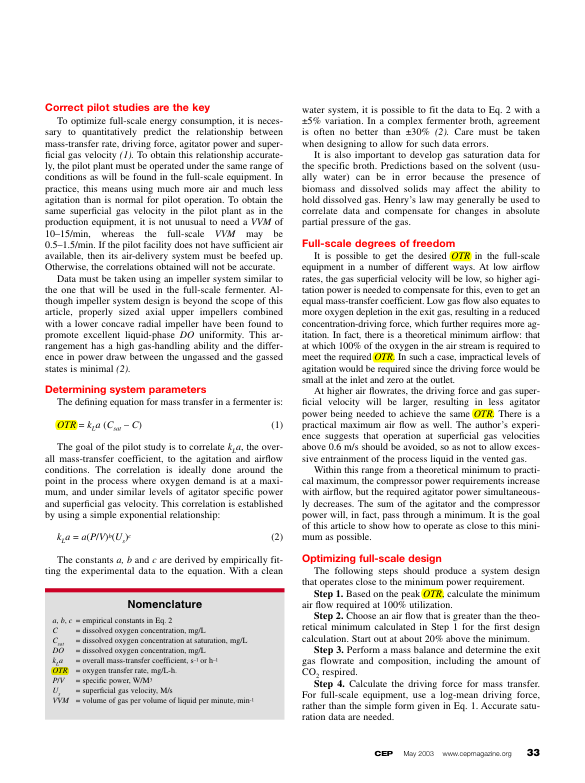

In [7]:
import pymupdf  # import package PyMuPDF
document_path = document_paths['article']
doc=pymupdf.open(document_path)

#highlight word on page
page = doc[1]
areas = page.search_for("OTR")
page.add_highlight_annot(areas)

from IPython.display import display, Image
pix = page.get_pixmap()
display(Image(data=pix.tobytes()))

## PyMuPDF4LLM

Seems it is not layout aware.

In [4]:
import pymupdf4llm
document_path = document_paths['article']
res = pymupdf4llm.to_markdown(document_path, page_chunks=True)
display(res[0])
# llama index integration
llama_reader = pymupdf4llm.LlamaMarkdownReader()
llama_docs = llama_reader.load_data(document_path)

Processing ../data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf...
]========================================] (4/4)


{'metadata': {'format': 'PDF 1.3',
  'title': 'New Title',
  'author': '',
  'subject': 'New Subject',
  'keywords': 'New Keywords',
  'creator': '',
  'producer': 'Acrobat Distiller 4.0 for Macintosh',
  'creationDate': 'D:20030416141111Z',
  'modDate': "D:20100323141325-04'00'",
  'trapped': '',
  'encryption': 'Standard V1 R2 40-bit RC4',
  'file_path': '../data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf',
  'page_count': 4,
  'page': 1},
 'toc_items': [],
 'tables': [],
 'images': [],
 'graphics': [],
 'text': '### Reactions and Separations\n\n## Optimize Power\n Consumption in Aerobic Fermenters\n\n\n**Gregory T. Benz**\nBenz Technology International, Inc.\n\n\n### By performing the necessary pilot work, and rigorously calculating the full-scale performance instead of using simple rules-of-thumb for scale-up, significant energy savings can be achieved in fermenters.\n\n\nEROBIC FERMENTATION WAS PUT TO\ncommercial use in the 1940s to make penicillin. Later,

Successfully imported LlamaIndex
Processing ../data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf...
]========================================] (1/1)
Processing ../data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf...
]========================================] (1/1)
Processing ../data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf...
]========================================] (1/1)
Processing ../data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf...
]========================================] (1/1)


## Py Zerox

Advanced approach with OCR from poppler

In [35]:
from pyzerox import zerox
import os
import json
import asyncio

### Model Setup (Use only Vision Models) Refer: https://docs.litellm.ai/docs/providers ###

## placeholder for additional model kwargs which might be required for some models
kwargs = {}

## system prompt to use for the vision model
custom_system_prompt = None

# to override
# custom_system_prompt = "For the below pdf page, do something..something..." ## example

###################### Supported Models and ENV vars ######################
# For other providers refer: https://docs.litellm.ai/docs/providers 
models = {
    'openai' : "gpt-4o-mini", #OPENAI_API_KEY
    'gemini' : "gemini/gemini-1.5-flash", #GEMINI_API_KEY
    'anthropic' : "claude-3-5-sonnet-20241022", #ANTHROPIC_API_KEY
}

model = models['gemini']

###### Define main async entrypoint
async def extract_markdown(filepath, provider: str = 'gemini'):
    if provider in models.keys():
        model=models[provider]
    else:
        raise KeyError(f"provider not supported, choose from {list(models.keys())}")
    
    # KWARGS docs: https://docs.litellm.ai/docs/completion/input
    
    ## local filepath and file URL supported
    file_path = str(pathlib.Path(filepath).resolve())

    ## process only some pages or all
    select_pages = None ## None for all, but could be int or list(int) page numbers (1 indexed)

    output_dir = "./output_test" ## directory to save the consolidated markdown file
    result = await zerox(
        file_path=file_path, 
        model=model, 
        output_dir=None,
        custom_system_prompt=custom_system_prompt,
        select_pages=select_pages, 
        **kwargs
    )
    return result


# run the main function:
document_path = document_paths['article']
result = await extract_markdown(filepath=document_path)

# print markdown result
print(result.pages[1].content)

Correct pilot studies are the key

To optimize full-scale energy consumption, it is necessary to quantitatively predict the relationship between mass-transfer rate, driving force, agitator power and superficial gas velocity (1). To obtain this relationship accurately, the pilot plant must be operated under the same range of conditions as will be found in the full-scale equipment. In practice, this means using much more air and much less agitation than is normal for pilot operation. To obtain the same superficial gas velocity in the pilot plant as in the production equipment, it is not unusual to need a VVM of 10–15/min, whereas the full-scale VVM may be 0.5–1.5/min. If the pilot facility does not have sufficient air available, then its air-delivery system must be beefed up. Otherwise, the correlations obtained will not be accurate. Data must be taken using an impeller system similar to the one that will be used in the full-scale fermenter. Although impeller system design is beyond the 

## Marker PDF

Only works on new versions of pytorch (i.e. not mac silicon)

In [24]:
import os

from marker.converters.pdf import PdfConverter

from marker.config.parser import ConfigParser
from marker.config.printer import CustomClickPrinter
from marker.logger import configure_logging
from marker.models import create_model_dict
from marker.output import save_output

configure_logging()


def convert_single(fpath:str):
    models = create_model_dict()
    start = time.time()
    config_parser = ConfigParser(kwargs)

    converter_cls = PdfConverter
    converter = converter_cls(
        config=config_parser.generate_config_dict(),
        artifact_dict=models,
        processor_list=config_parser.get_processors(),
        renderer=config_parser.get_renderer()
    )
    rendered = converter(fpath)
    print(f"Total time: {time.time() - start}")
    return rendered


ModuleNotFoundError: No module named 'marker.converters'

In [20]:
from marker.converters.pdf import PdfConverter
from marker.models import create_model_dict
from marker.output import text_from_rendered

document_path = document_paths['article']

converter = PdfConverter(
    artifact_dict=create_model_dict(),
)

rendered = converter(document_path)
text, _, images = text_from_rendered(rendered)

ModuleNotFoundError: No module named 'marker.converters'

# Web Search

## List of wiki URLs

In [15]:
wiki_pages = [
    'https://en.wikipedia.org/wiki/Chemical_plant',
    'https://en.wikipedia.org/wiki/Centrifugation',
    'https://en.wikipedia.org/wiki/Chromatography',
    'https://en.wikipedia.org/wiki/Crystallization',
    'https://en.wikipedia.org/wiki/Decantation',
    'https://en.wikipedia.org/wiki/Demister_(vapor)',
    'https://en.wikipedia.org/wiki/Distillation',
    'https://en.wikipedia.org/wiki/Drying',
    'https://en.wikipedia.org/wiki/Mineral_processing',
    'https://en.wikipedia.org/wiki/Evaporation',
    'https://en.wikipedia.org/wiki/Extraction_(chemistry)',
    'https://en.wikipedia.org/wiki/Filtration',
    'https://en.wikipedia.org/wiki/Membrane_technology',
    'https://en.wikipedia.org/wiki/Microfiltration',
    'https://en.wikipedia.org/wiki/Ultrafiltration',
    'https://en.wikipedia.org/wiki/Nanofiltration',
    'https://en.wikipedia.org/wiki/Reverse_osmosis',
    'https://en.wikipedia.org/wiki/Dialysis_(chemistry)',
    'https://en.wikipedia.org/wiki/Flocculation',
    'https://en.wikipedia.org/wiki/Fractional_distillation',
    'https://en.wikipedia.org/wiki/Fractional_freezing',
    'https://en.wikipedia.org/wiki/Precipitation_(chemistry)',
    'https://en.wikipedia.org/wiki/Unit_operation',
    'https://en.wikipedia.org/wiki/Industrial_processes',
    'https://en.wikipedia.org/wiki/Chemical_reactor',
    'https://en.wikipedia.org/wiki/Fermentation',
    'https://en.wikipedia.org/wiki/Heat_exchanger',
    'https://en.wikipedia.org/wiki/Cooling_tower',
    'https://en.wikipedia.org/wiki/Chiller',
    'https://en.wikipedia.org/wiki/Material-handling_equipment',
    'https://en.wikipedia.org/wiki/Industrial_enzymes',
    'https://en.wikipedia.org/wiki/Modular_process_skid',
    'https://en.wikipedia.org/wiki/Process_design',
    'https://en.wikipedia.org/wiki/Compressor',
    'https://en.wikipedia.org/wiki/Mixing_(process_engineering)',
    'https://en.wikipedia.org/wiki/Storage_tank#Use_for_chemicals',
]



## Brave Search

In [11]:
from brave import Brave

brave = Brave()

query = "Crystallization unit operation"
num_results = 10

search_results = brave.search(q=query, count=num_results)
web_results = search_results.web_results
for r in web_results:
    print("\n")
    print(f"{r['title']}")
    print(f"- {r['url']}")
    print(f"- {r['description']}")



Unit Operations in Food Processing - R. L. Earle
- https://nzifst.org.nz/resources/unitoperations/conteqseparation10.htm
- CHAPTER 9 CONTACT EQUILIBRIUM PROCESSES - APPLICATIONS (cont&#x27;d) <strong>CRYSTALLIZATION</strong> · <strong>Crystallization</strong> Equilibrium Solubility Heat of crystallisation Rate of <strong>Crystal</strong> Growth Stage-equilibrium <strong>Crystallization</strong> <strong>Crystallization</strong> Equipment <strong>Crystallization</strong> is an example of a separation process in which ...


Crystallization
- https://ethz.ch/content/dam/ethz/special-interest/mavt/process-engineering/separation-processes-laboratory-dam/documents/practica%20in%20process%20engineering%202/crystallization.pdf
- The current request could not be completed due to an internal error or misconfiguration · Please try again in a few minutes or contact the ETH IT Services and refer to the below error code


Crystallization - Wikipedia
- https://en.wikipedia.org/wiki/Crystallization
-

## Wikipedia

In [35]:
import wikipedia

res = wikipedia.search("Separation process", results=10)
pages = []
for r in res:
    print(f"-------------------\n'{r}'")

    try:
        summary = wikipedia.summary(r, sentences=1)
        print(summary)
        page = wikipedia.page(r)
        pages.append(page)
        print(page.url)
    except Exception as e:
        print(f"failed due to {type(e)}")

-------------------
'Separation process'
A separation process is a method that converts a mixture or a solution of chemical substances into two or more distinct product mixtures, a scientific process of separating two or more substances in order to obtain purity.
https://en.wikipedia.org/wiki/Separation_process
-------------------
'Membrane technology'
Membrane technology encompasses the scientific processes used in the construction and application of membranes.
https://en.wikipedia.org/wiki/Membrane_technology
-------------------
'Color printing'
failed due to <class 'wikipedia.exceptions.PageError'>
-------------------
'Eggshell membrane separation process'
Eggshell membrane separation is a recycling process to separate the protein-rich eggshell membrane from the eggshell.
https://en.wikipedia.org/wiki/Eggshell_membrane_separation_process
-------------------
'Industrial separation processes'
Industrial separation processes are technical procedures which are used in industry to separa

In [44]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia(
    user_agent='ragnostic (nicholasgrundl@gmail.com)', 
    language='en',
    extract_format=wikipediaapi.ExtractFormat.HTML,
)

page_py = wiki_wiki.page('Separation process')
print("Page - Title: %s" % page_py.title)
print("Page - Summary: %s" % page_py.summary[0:60])

def print_sections(sections, level=0):
    for s in sections:
        print("%s: %s - %s" % ("*" * (level + 1), s.title, s.text[0:40]))
        print_sections(s.sections, level + 1)
print_sections(page_py.sections)

#show HTML
from IPython.core.display import HTML
display(HTML(page_py.text))

Page - Title: Separation process
Page - Summary: <p>A <b>separation process</b> is a method that converts a m
*: Complete and incomplete separation - <p>Some types of separation require comp
*: List of separation techniques - <ul><li>Centrifugation and cyclonic sepa
*: See also - <ul><li>Analytical chemistry – Study of 
*: References - 
*: Further reading - <ul><li><cite id="CITEREFNational_Academ
*: External links - <ul><li>Separation of Mixtures Using Dif
